<a href="https://colab.research.google.com/github/diaputr/pcvk/blob/main/Testing_Week13_Kuis2_Kelompok_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kelompok 6**

Agus Prayogi (05 | 2141720025)

Diah Putri Nofianti (12 | 2141720054)

Tarista Dwi Silvia (26 | 2141720014)

# Panduan Kuis 2 Praktikum

1. Mengerjakan secara kelompok yang terdiri dari 3 anggota.

2. Kumpulkan e-ktp anggota keluarga pada kelompok minimal 9 buah sebagai dataset.

3. Deteksi dan kenali foto wajah e-ktp tersebut menggunakan metode yang telah dipelajari, baik pada mata kuliah PCVK ataupun mata kuliah lain pada semester ini.

4. Presentasikan di depan kelas hasil dari pekerjaan kelompok, paparkan hasil dari pekerjaan tersebut secara detail lengkap dengan tangkapan layar bagian dari; (1) pre-processing, (2) lokalisasi, (3) segmentasi, dan (4) pengenalan.

5. Jangan lupa upload juga kode program tersebut pada repository.

6. Kumpulkan link file presentasi dalam bentuk pdf dan link repository.

In [444]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/Shareddrives/Kita/Kuliah/SMT5/PCVK/Kuis2/ktp'
# ktpMorePath = '/content/drive/Shareddrives/Kita/Kuliah/SMT5/PCVK/KTP_More'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [445]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt-get install tesseract-ocr-ind # model untuk bahasa indonesia

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-ind is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [446]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
from PIL import Image
from skimage.metrics import structural_similarity as ssim

import os
from tqdm import tqdm
import random
import pickle

from keras.models import load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, ZeroPadding2D
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

# Pre-processing

1751 2757 525.3 827.1


100%|██████████| 21/21 [00:00<00:00, 42.10it/s]


21


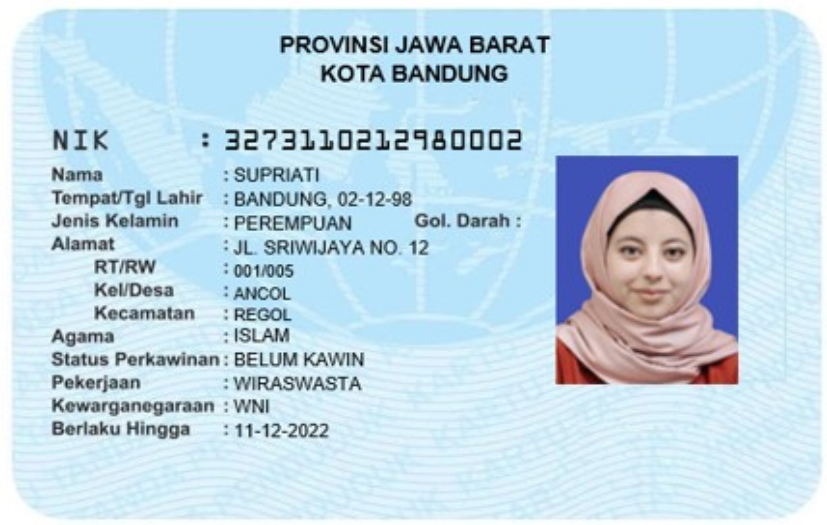

In [447]:
training_data = []

ktp_sample = cv.imread(f'{path}/KTP-puput.jpg')
w, h, c = ktp_sample.shape

width, height = w * 0.3, h * 0.3
print(w,h, width, height)

for img in tqdm(os.listdir(path)):
  try:
    img_array = cv.imread(os.path.join(path,img))
    new_array = cv.resize(img_array, (int(height),int(width)))
    training_data.append({
        'ktp': new_array,
    })
  except Exception as e:
    pass
# img_ktp = cv.imread(f'{ktpMorePath}/ktp2.png')
print(len(training_data))
img_ktp = training_data[3]['ktp']
cv2_imshow(img_ktp)

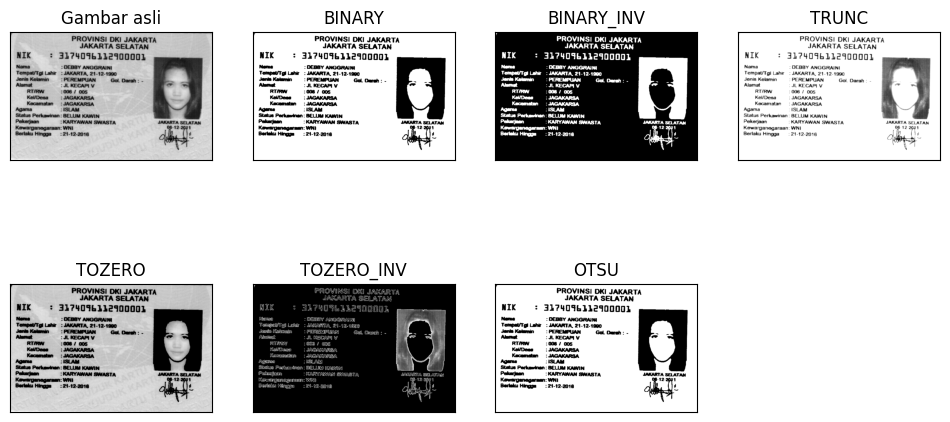

In [448]:
# Gaussian Blur untuk mengurangi noise
for i in range(len(training_data)):
  blurred = cv.GaussianBlur(training_data[i]['ktp'], (5, 5), 0.5)
  img_grey = cv.cvtColor(blurred, cv.COLOR_BGR2GRAY)
  training_data[i]['grey'] = img_grey

  ret,thresh1 = cv.threshold(img_grey,127,255,cv.THRESH_BINARY)
  ret,thresh2 = cv.threshold(img_grey,127,255,cv.THRESH_BINARY_INV)
  ret,thresh3 = cv.threshold(img_grey,127,255,cv.THRESH_TRUNC)
  ret,thresh4 = cv.threshold(img_grey,127,255,cv.THRESH_TOZERO)
  ret,thresh5 = cv.threshold(img_grey,127,255,cv.THRESH_TOZERO_INV)
  ret,thresh6 = cv.threshold(img_grey,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

  titles = ['Gambar asli','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV','OTSU']
  images = [img_grey, thresh1, thresh2, thresh3, thresh4, thresh5, thresh6]
  training_data[i]['trunc'] = thresh3
  training_data[i]['otsu'] = thresh6

# menampilkan 1 sample dalam beberapa algoritma gambar sekaligus
plt.figure(figsize=(12, 6))
for i in range(7):
    # 3 baris, 2 kolom
    plt.subplot(2,4,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

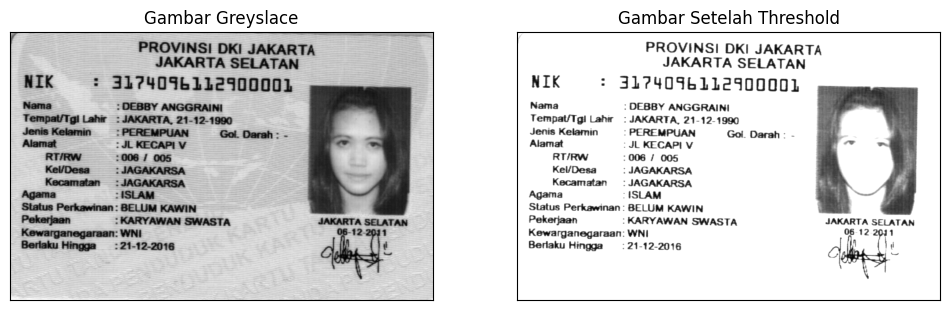

In [449]:
# tampilkan sample
plt.figure(figsize=(12, 6))
plt.subplot(121),plt.imshow(img_grey,cmap = 'gray')
plt.title('Gambar Greyslace'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(thresh3,cmap = 'gray')
plt.title('Gambar Setelah Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

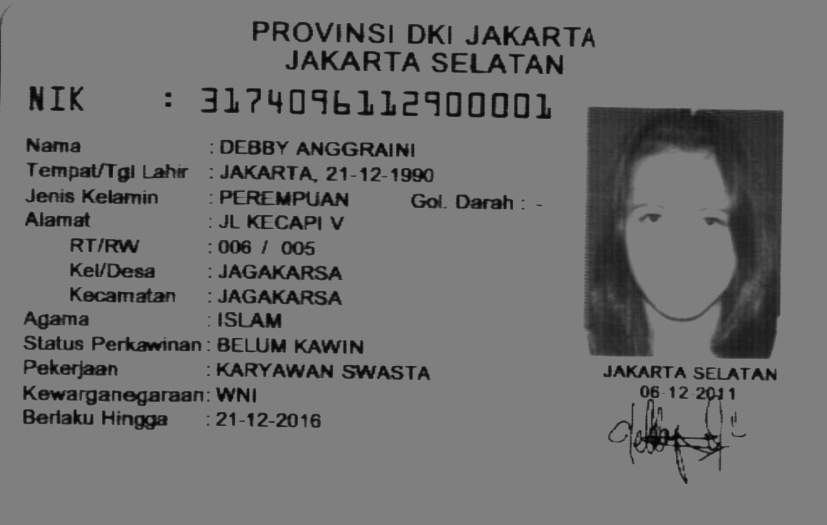

In [450]:
for i in range(len(training_data)):
  trunc = training_data[i]['trunc']
  kernel = cv.getStructuringElement(cv.MORPH_OPEN, (1, 1))
  erosion = cv.erode(trunc,kernel,iterations = 1)
  training_data[i]['erosion'] = erosion

# tampilkan sample
cv2_imshow(erosion)

In [451]:
for i in range(len(training_data)):
  grey = training_data[i]['grey']
  erosion = training_data[i]['erosion']
  trunc = training_data[i]['trunc']
  otsu = training_data[i]['otsu']
  print(f'{grey.shape} => {erosion.shape}')
  scoreErosion, _ = ssim(grey, erosion, full=True)
  scoreTrunc, _ = ssim(grey, trunc, full=True)
  scoreOtsu, _ = ssim(grey, otsu, full=True)
  print(f"Nilai SSIM untuk gambar : \n Erosi : {scoreErosion}\n Thresh Trunc : {scoreTrunc}\n Thresh Otsu : {scoreOtsu}")
  acuan = 0.4
  if scoreErosion <= acuan:
    img_result = erosion
  elif scoreTrunc <= acuan:
    img_result = trunc
  elif scoreOtsu <= acuan:
    img_result = otsu
  else:
    img_result = grey
  training_data[i]['result'] = img_result

(525, 827) => (525, 827)
Nilai SSIM untuk gambar : 
 Erosi : 0.5543538633327652
 Thresh Trunc : 0.5543538633327652
 Thresh Otsu : 0.40577425884619567
(525, 827) => (525, 827)
Nilai SSIM untuk gambar : 
 Erosi : 0.44145676709779924
 Thresh Trunc : 0.44145676709779924
 Thresh Otsu : 0.4131657502389884
(525, 827) => (525, 827)
Nilai SSIM untuk gambar : 
 Erosi : 0.6184292772001186
 Thresh Trunc : 0.6184292772001186
 Thresh Otsu : 0.6111421493474942
(525, 827) => (525, 827)
Nilai SSIM untuk gambar : 
 Erosi : 0.6422595013572735
 Thresh Trunc : 0.6422595013572735
 Thresh Otsu : 0.7060861909231054
(525, 827) => (525, 827)
Nilai SSIM untuk gambar : 
 Erosi : 0.657952328321882
 Thresh Trunc : 0.657952328321882
 Thresh Otsu : 0.6083345659841021
(525, 827) => (525, 827)
Nilai SSIM untuk gambar : 
 Erosi : 0.43192686421297005
 Thresh Trunc : 0.43192686421297005
 Thresh Otsu : 0.33567957828104755
(525, 827) => (525, 827)
Nilai SSIM untuk gambar : 
 Erosi : 0.5572345072031231
 Thresh Trunc : 0.5572

# Lokalisasi

In [452]:
for i in range(len(training_data)):
  # merubah gamabar menjadi text
  img_result = training_data[i]['result']
  result = pytesseract.image_to_string(img_result, lang="ind")

  # penampung hasil kalimat
  texts = []
  # Normalisasi kata yang salah
  for word in result.split("\n"):
    if "”—" in word:
      word = word.replace("”—", "")
    if "—" in word:
      word = word.replace("—", "")
    if "”:" in word:
      word = word.replace("”:", "")
    if ":" in word:
      word = word.replace(":", "")

    #normalize NIK
    if "NIK" in word:
      nik_char = word.split()
      if "D" in word:
        word = word.replace("D", "0")
      if "?" in word:
        word = word.replace("?", "7")
    texts.append(word)
  training_data[i]['txt'] = texts

In [453]:
def clear_text_nama(txt):
  txt = txt.replace('-', "")
  txt = txt.replace('1', "")
  txt = txt.replace('"', "")
  txt = txt.replace('slui', "luki")
  txt = txt.replace('cm', "ch")
  # Temukan indeks dari kemunculan terakhir karakter ","
  num_txt = txt.split(" ")

  # Jika ada koma, ganti hanya yang paling belakang
  if len(num_txt) > 1:
    ltxt = num_txt.pop().replace(',', '')
    text = [' '.join(num_txt), ltxt]
    txt = ' '.join(text)
  return txt.strip().title()

In [454]:
# kata yang dicari
selected_field = ['nama']

for i in range(len(training_data)):
  selected_items = {}
  texts = training_data[i]['txt']
  for text in texts:
    text_formated = text.strip().lower()
    for selected in selected_field:
      if selected in text_formated:
        select = text_formated.replace(selected, "")
        selected_items[selected] = clear_text_nama(select)
        # if len(space_split) <= 2:
        #   selected_items[selected] = space_split.pop().title()
        # else:
        #   rest = space_split[1:]
        #   selected_items[selected] = ' '.join(rest).title()

  if len(selected_field) == len(selected_items):
    training_data[i]['selected'] = selected_items
    training_data[i]['nama'] = selected_items['nama']
  else:
    training_data[i]['nama'] = 'empty'

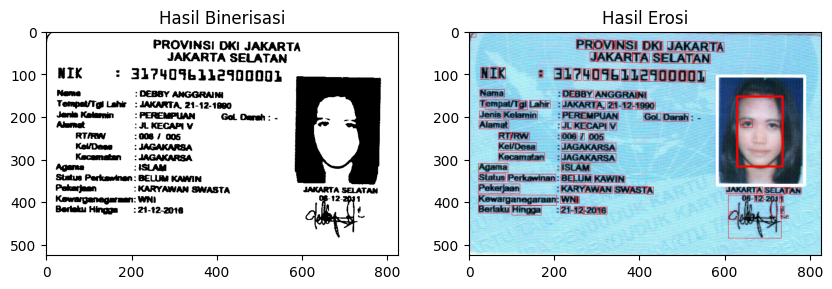

In [455]:
for i in range(len(training_data)):
  img_ktp = training_data[i]['ktp']
  img_ktp2 = img_ktp.copy()
  img_ktp3 = img_ktp.copy()
  # Ekstraksi kontur
  otsu = training_data[i]['otsu']
  contours, hierarchy = cv.findContours(otsu, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

  # mencari ukuran dari foto
  w, h = otsu.shape
  min_w = 0.25 * w
  min_h = 0.25 * h

  # Looping kontur untuk pemilihan berdasarkan ukuran dan rasio
  for cnt in contours:
      x, y, w, h = cv.boundingRect(cnt)
      ras = format(w / h, '.2f')
      if h >= min_h and w >= min_w and float(ras) <= 1:
          cv.rectangle(img_ktp2, (x, y), (x + w, y + h), (255, 255, 255), thickness=5)
          foto = img_ktp3[y:(y+h),x:(x+w)] # crop foto
          training_data[i]['coordinate'] = {
              'x': x,
              'y': y,
              'h': h,
              'w': w,
          }
          training_data[i]['foto'] = foto
      elif h >= 40 and w >= 10 and float(ras) <= 1:
          cv.rectangle(img_ktp2, (x, y), (x + w, y + h), (0, 0, 255), thickness=3)
      elif h >= 8 and w >= 8 and float(ras) <= 10:
          cv.rectangle(img_ktp2, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)
      elif h >= 10 and w >= 7 and float(ras) <= 8:
          cv.rectangle(img_ktp2, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)
  training_data[i]['kontur'] = img_ktp2

# Menampilkan gambar sample
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title('Hasil Binerisasi')
axs[0].imshow(thresh6, cmap='gray')

axs[1].set_title('Hasil Erosi')
axs[1].imshow(cv.cvtColor(img_ktp2, cv.COLOR_BGR2RGB))

plt.show()

# Segmentasi

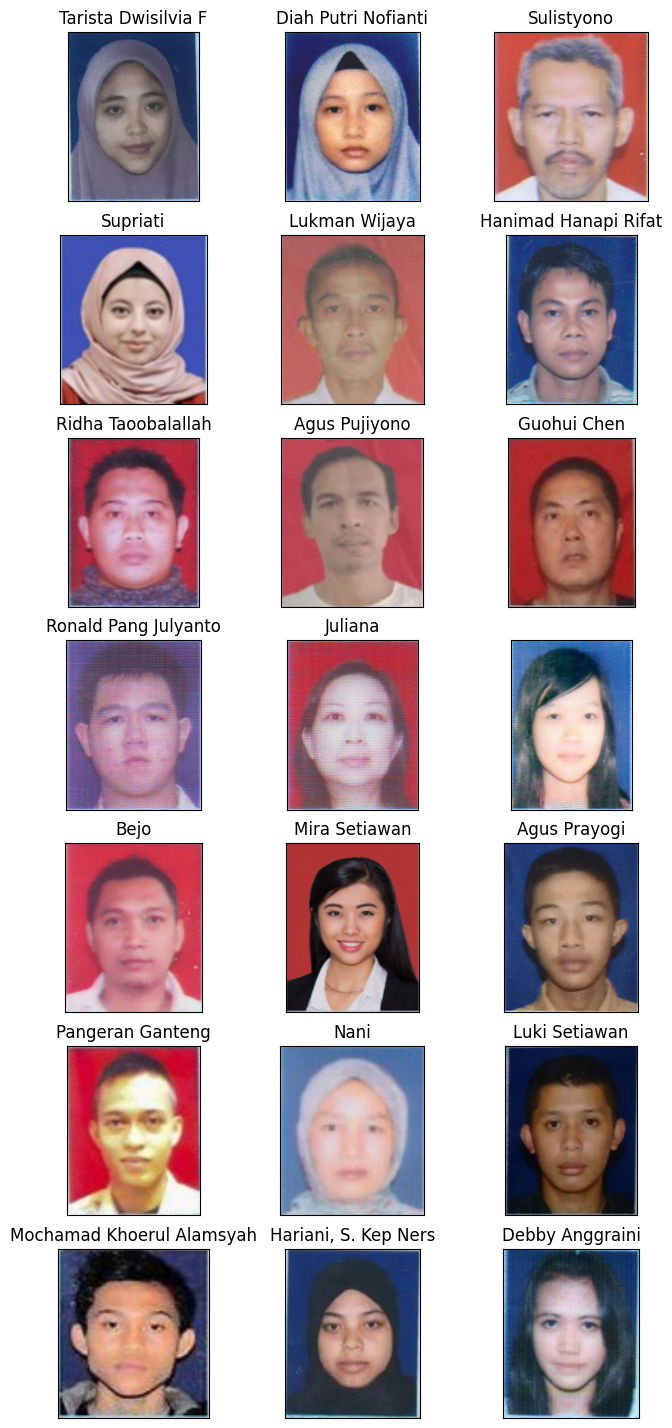

In [456]:
plt.figure(figsize=(8, 18))
for i in range(len(training_data)):
    # 3 baris, 2 kolom
    plt.subplot(7,3,i+1),plt.imshow(cv.cvtColor(training_data[i]['foto'], cv.COLOR_BGR2RGB))
    # plt.subplot(7,3,i+1),plt.imshow(training_data[i]['result'], cmap='gray')
    plt.title(training_data[i]['nama'])
    plt.xticks([]),plt.yticks([])
plt.show()

In [457]:
X = []
Y = []
sample_foto = cv.cvtColor(training_data[0]['foto'], cv.COLOR_BGR2GRAY)
h, w = sample_foto.shape
width, height = int(w*0.5), int(h*0.5)

data_train = []

for i in range(len(training_data)):
  grey = cv.cvtColor(training_data[i]['foto'], cv.COLOR_BGR2GRAY)
  new_array = cv.resize(grey, (width, height))
  data_train.append([new_array, i])

random.shuffle(data_train)
X = []
Y = []

for features, label in data_train:
  X.append(features)
  Y.append(label)

X = np.array(X).reshape(-1, width, height, 1)

# Tulis ke file pickle
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("Y.pickle", "wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

In [458]:
# Load file pickle
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("Y.pickle", "rb")
Y = pickle.load(pickle_in)
Y = to_categorical(Y)
X = X / 255.0
# # Input layer
inputs = Input(shape=(width, height, 1))
conv_layer = ZeroPadding2D(padding=(2, 2))(inputs)
conv_layer = Conv2D(16, (5, 5), strides=(1, 1), activation='relu')(conv_layer)
conv_layer = MaxPooling2D((2, 2))(conv_layer)
conv_layer = Conv2D(32, (3, 3), strides=(1, 1), activation='relu')(conv_layer)
conv_layer = Conv2D(32, (3, 3), strides=(1, 1), activation='relu')(conv_layer)
conv_layer = MaxPooling2D((2, 2))(conv_layer)
conv_layer = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(conv_layer)

flaten = Flatten()(conv_layer)
fc_layer = Dense(256, activation='relu')(flaten)
fc_layer = Dense(64, activation='relu')(fc_layer)

# Output layer dense harus sama banyak categorinya
outputs = Dense(Y.shape[0], activation='softmax')(fc_layer)
adam = Adam(learning_rate=0.0001)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X, Y, epochs=74, verbose=1)
model.save('e-ktp.model')

Epoch 1/74
1/1 [==============================] - 2s 2s/step - loss: 3.0556 - accuracy: 0.0000e+00
Epoch 2/74
1/1 [==============================] - 1s 548ms/step - loss: 3.0407 - accuracy: 0.0952
Epoch 3/74
1/1 [==============================] - 1s 510ms/step - loss: 3.0336 - accuracy: 0.0952
Epoch 4/74
1/1 [==============================] - 0s 474ms/step - loss: 3.0244 - accuracy: 0.0476
Epoch 5/74
1/1 [==============================] - 0s 474ms/step - loss: 3.0125 - accuracy: 0.0952
Epoch 6/74
1/1 [==============================] - 0s 464ms/step - loss: 3.0022 - accuracy: 0.0476
Epoch 7/74
1/1 [==============================] - 0s 483ms/step - loss: 2.9869 - accuracy: 0.0476
Epoch 8/74
1/1 [==============================] - 0s 477ms/step - loss: 2.9724 - accuracy: 0.2381
Epoch 9/74
1/1 [==============================] - 0s 454ms/step - loss: 2.9558 - accuracy: 0.2381
Epoch 10/74
1/1 [==============================] - 1s 514ms/step - loss: 2.9393 - accuracy: 0.1905
Epoch 11/74
1/1 [=

# Pengenalan

In [459]:
test_data = []
model = load_model("e-ktp.model")
for i in range(len(training_data)):
  grey = cv.cvtColor(training_data[i]['foto'], cv.COLOR_BGR2GRAY)
  new_array = cv.resize(grey, (width, height))
  test_data.append([new_array, i])

1/1 [==============================] - 0s 34ms/step


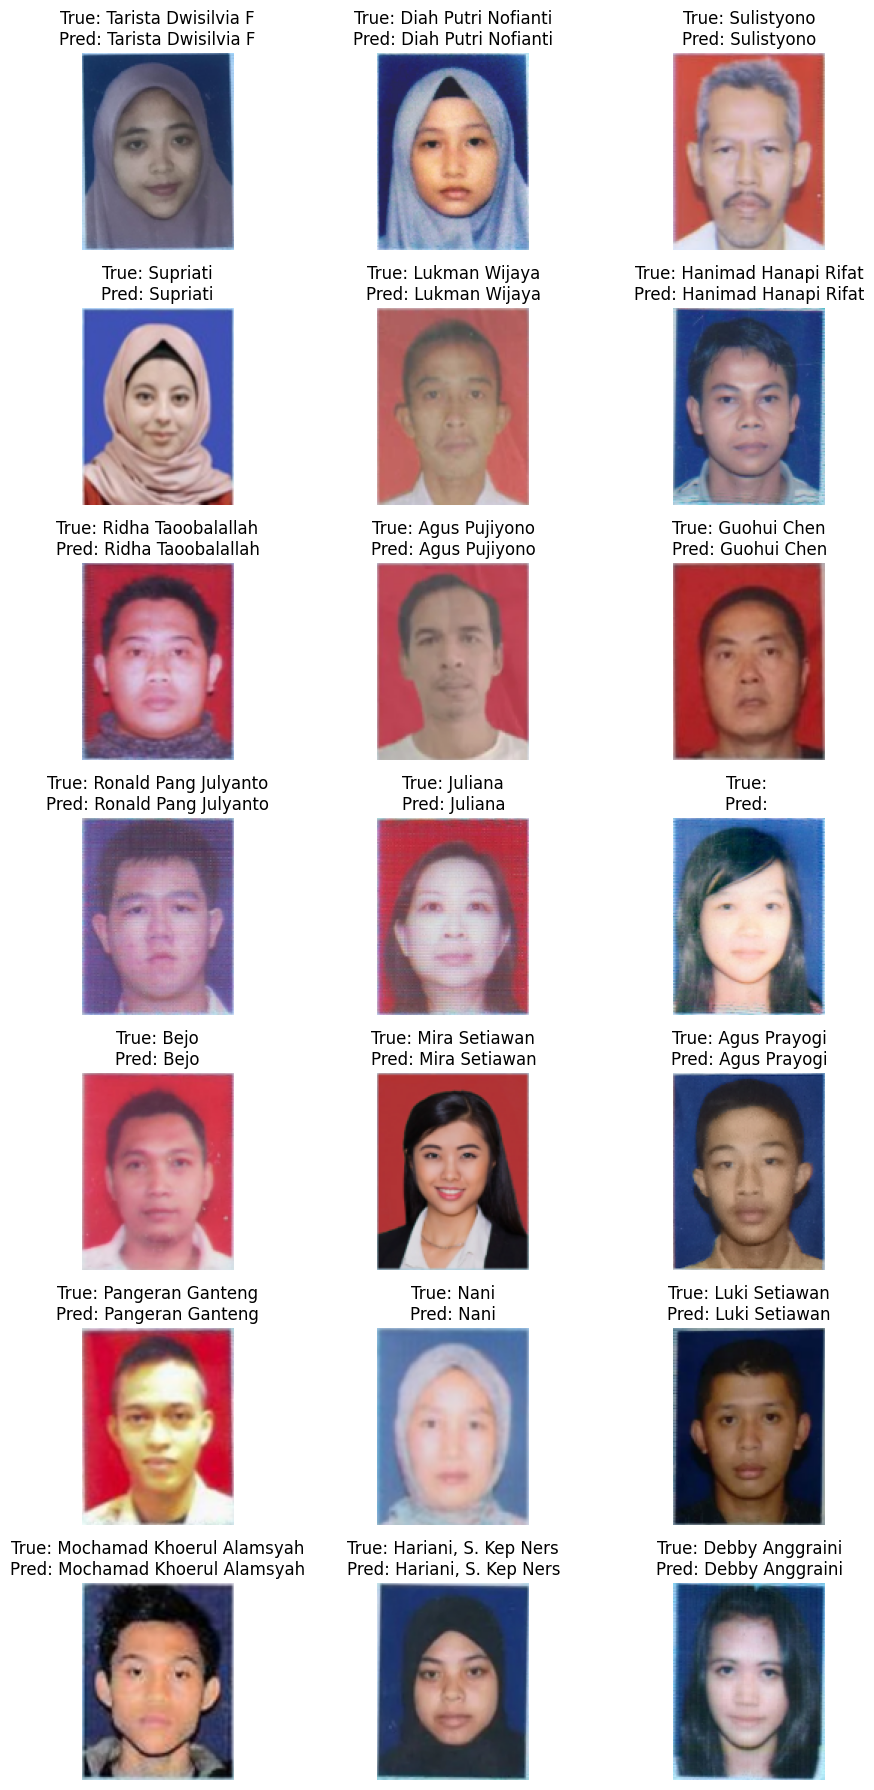

In [460]:
n_wrong = 0

plt.figure(figsize=(10, 18))
for i in range(len(test_data)):
  photo, _ = test_data[i]
  new_array = np.array(photo).reshape(-1, width, height, 1)
  new_array = new_array / 255.0
  prediction = model.predict(new_array)
  index = np.argmax(prediction[0]) # ambil label
  # print(f"Asli => {training_data[i]['nama']} || Prediksi => {training_data[index]['nama']}")

  # Display images with true labels and predicted labels

  plt.subplot(7, 3, i + 1)
  img = cv.cvtColor(training_data[i]['foto'], cv.COLOR_BGR2RGB)
  img = cv.resize(img, (width, height))
  plt.imshow(img)

  # Determine text color based on true or predicted
  true_label = training_data[i]['nama']
  pred_label = training_data[index]['nama']

  if true_label == pred_label:
      text_color = 'black'
  else:
      text_color = 'red'
      n_wrong += 1

  plt.title(f"True: {true_label}\nPred: {pred_label}", color=text_color)
  plt.axis("off")

plt.tight_layout()
plt.show()

In [462]:
print(f'Akurasi Model: {(((21-n_wrong)/21)*100):.2f}%')

Akurasi Model: 100.00%
